![ai_robo_kr_logo](https://user-images.githubusercontent.com/12381733/115536894-3708f600-a2d5-11eb-92db-44521460a1ba.jpg)

# [AI Robotics Korea] Sensor Fusion Study - SLAM++ Team

## Author

- 김수영
- 강한솔

PyICP를 통해 Lidar SLAM을 실행시켜보고, 그 작동원리를 이해해봅니다. 이 모든 과정은 python을 통해 가능합니다.

> Special thanks to [Giseop Kim](https://github.com/gisbi-kim) and His Repo

## 목차:
* [PyICP 실행 준비](#PyICP-실행-준비)
* [PyICP 간단하게 살펴보기](#PyICP-간단하게-살펴보기)
* [Main-Loop-실행](#Main-Loop-실행)
* [결과 분석](#결과-분석)

# **PyICP** 실행 준비 <a class="anchor" id="PyICP-실행-준비"></a>

 종속성인 [minisam](https://github.com/dongjing3309/minisam) / [pykitti](https://github.com/utiasSTARS/pykitti) 가 잘 설치되어 있는지 확인합니다. 

In [1]:
!pip list | grep mini

minisam                       0.0.0


In [2]:
!pip list | grep pykitti

pykitti                       0.3.1


## 패키지들을 import 해줍니다.

In [3]:
import os
import sys
import csv
import copy
import time
import random
import argparse

import numpy as np
np.set_printoptions(precision=4)

%matplotlib inline
from matplotlib.animation import FFMpegWriter

from tqdm import tqdm

import pykitti

**utils**폴더로부터 다음 모듈들을 가져옵니다.
* **ScanContextManager** : loop closure detection을 담당하는 scan context를 handle하는 부분입니다.
* **PoseGraphManager** : minisam에 기반하여 새로운 pose가 들어올 때마다 graph를 확장하고, loop closure가 감지되면 back-end optimization을 진행합니다.
* **UtilsMisc** : miscellaneous(잡다한)이라는 이름에 걸맞게 생성된 pose graph를 정적 파일로 저장하는 PoseGraphResultSaver, loop closure detection이후 회전각을 다루는 yawdeg2se3등의 여러 utility가 담긴 파일입니다.
* **UtilsPointcloud** : KITTI Dataset을 불러들이고, 순회하는 util이 담겨 있는데요, 사실 pykitti를 사용하게 되면서 큰 효율성은 갖지 않습니다. 리펙토링 시에 다른 utils로 병합될 예정입니다.

In [4]:
from minisam import *
from utils.ScanContextManager import *
from utils.PoseGraphManager import *
from utils.UtilsMisc import *
import utils.UtilsPointcloud as Ptutils
import utils.ICP as ICP

### PyICP 전반에 걸쳐 필요한 매개변수들을 설정합니다.

ICP Params
* **num_icp_points** : velodyne point cloud수가 너무 많기 때문에 랜덤 5000개의 point들만 선별합니다.

Scan Context Params
* **num_rings** / **num_sectors** : scan context의 가로, 세로에 해당하는 ring, sector 값을 선언합니다.
* **num_candidates** : loop closure detection 시, 현재의 scan context와 유사한 N개의 후보들을 뽑아 그중 가장 비슷한 scan context를 선별합니다. 이 과정에서 몇개의 후보들을 뽑을 것인지에 관한 값입니다. 개수이기 때문에 양의 정수 값을 취합니다.
* **loop_threshold** : 두 scan context의 차이를 계산하여, 차이가 이 값보다 큰 경우는 유사하지 않다고 간주하고 이후 과정을 무시합니다.

Batch Params
* **try_gap_loop_detection** : 매 timestamp 마다 loop detection을 계산하면 엄청난 연산이 발생합니다. 이렇게 하는 대신, 이 매개변수 만큼의 step을 갖고 loop closure를 계산하게 됩니다.
* **save_gap** : try_gap_loop_detection과 비슷한 역할을 합니다. 매 cycle마다 결과를 저장하지 않고, 이 값의 배수에 해당되는 pose를 csv 형식으로 저장합니다.

In [5]:
num_icp_points = 5000 # 5000 is enough for real time

num_rings = 30 #20 # same as the original paper
num_sectors = 70 #60 # same as the original paper
num_candidates = 20 #10 # must be int
try_gap_loop_detection = 10 # same as the original paper

loop_threshold = 0.11 # 0.11 is usually safe (for avoiding false loop closure)

save_gap = 300

### pykitti를 사용하여 odometry dataset을 추가해줍니다.

> 기존 PyICP는 [Odometry Dataset](http://www.cvlibs.net/datasets/kitti/eval_odometry.php)을 사용한 반면, 스터디를 위해 공통된 Raw Dataset을 사용하였습니다.


Dataset Params

* **kitti_root_dir** : `KITTI dataset`의 위치를 설정합니다. 이 설정은 사용자가 dataset을 어디에 다운로드 받았느냐에 따라 달라집니다.
* **kitti_date** / **kitti_drive** : 제가 사용한 Dataset 푤더의 구조를 하단에 표기해 두었습니다. Dataset을 다운받고 압축을 풀게 되면, `2011_09_30_drive_0033_sync`와 같은 이름으로 구성된 폴더가 나오는데요, 이때, **2011_09_30**는 **kitti_date**에 해당하고, **0033**는 **kitti_drive**에 해당하게 됩니다.

```
2011_09_30
├── 2011_09_30_drive_0033_sync
│   ├── image_00
│   ├── image_01
│   ├── image_02
│   ├── image_03
│   ├── oxts
│   └── velodyne_points
├── calib_cam_to_cam.txt
├── calib_imu_to_velo.txt
└── calib_velo_to_cam.txt
```

In [6]:
kitti_root_dir = '/home/kimsooyoung/Documents/AI_KR'
kitti_date = '2011_09_30'
kitti_drive = '0033'

# dataset = pykitti.odometry(data_base_dir, sequence_idx)
dataset = pykitti.raw(kitti_root_dir, kitti_date, kitti_drive)

## Dataset이 제대로 추가 되었나 궁금하시죠? 확인해봅시다. 😁

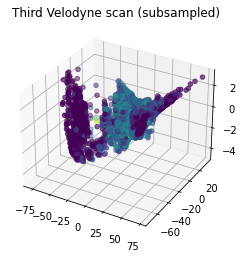

In [7]:
num_frames = len(dataset)
third_velo = dataset.get_velo(2)

f2 = plt.figure()
ax2 = f2.add_subplot(111, projection='3d')
# Plot every 100th point so things don't get too bogged down
velo_range = range(0, third_velo.shape[0], 10)
ax2.scatter(third_velo[velo_range, 0],
            third_velo[velo_range, 1],
            third_velo[velo_range, 2],
            c=third_velo[velo_range, 3],
            # cmap='gray'
            )
ax2.set_title('Third Velodyne scan (subsampled)')

plt.show()

> ### Point Cloud Scatter가 잘 보였다면 성공입니다!!!

## 설정해준 매개변수들을 가지고, 이제 본격적인 PyICP를 살펴보겠습니다.  <a class="anchor" id="PyICP-간단하게-살펴보기"></a>


## Initialize Pose Graph 

PyICP는 minisam이라는 [GSTAM](https://gtsam.org/)에 기반한 framework를 사용합니다.
새로운 Pose가 들어오면 이전 Pose들과 연관짓고,
Loop Closure가 Detect 될 시에는 전체를 최적화하는 작업을 수행합니다.

In [8]:
# Pose Graph Manager (for back-end optimization) initialization
PGM = PoseGraphManager()
PGM.addPriorFactor()

## Result saver

KITTI Dataset에서, Pose는 **4x4 homogeneous pose matrix**로 표현됩니다.
```

r11 r12 r13 tx
r21 r22 r23 ty
r31 r32 r33 tz
0   0   0   1
```

이 Matrix는 위와 같이 **rotation**과 **translation**을 담고 있습니다.

PyICP는 이들을 주르륵 펼치고, csv형식으로 저장하는데요, 하단은 이에 대한 설정입니다.

* **save_dir** : csv 결과 파일을 저장할 폴더 
* **PoseGraphResultSaver** : 파일 입출력을 편하게 도와주는 Manager입니다.

In [12]:
# Result saver
save_dir = "result/" + kitti_drive

if not os.path.exists(save_dir): 
    os.makedirs(save_dir)
    
ResultSaver = PoseGraphResultSaver(init_pose=PGM.curr_se3, 
                                     save_gap=save_gap,
                                     num_frames=num_frames,
                                     seq_idx=kitti_drive,
                                     save_dir=save_dir)

## Initialize  Scan Context Mananger

PyICP는 Scan Context를 통해 loop closure를 detect합니다.
이에 대한 간략한 설명은 따로 Notion으로 정리해 두었으며, 여기서는 직관적인 움짤과 함께 간단히 알아보겠습니다.

<img src="https://user-images.githubusercontent.com/12381733/111986526-65b67400-8b51-11eb-95db-222bc2fc0561.gif" width="250" height="250"/>

간단히 말해서, Scan Context는 **3D Lidar Point Cloud**를 **2차원 벡터**로 변환합니다.
2차원 하단을 보면 마치 이미지가 생성되는 것처럼 보이지요? 사실 이미지가 곧 2차원 벡터이기 때문에 그렇습니다.

이미지가 되었다? 혹시 **Convolution Network**를 사용하면 어떨까라는 연상이 떠오르시나요??

[Scan Context Github Repo](https://github.com/irapkaist/scancontext)를 살펴보면, 이에 대한 내용도 다루고 있으니 한번씩 살펴보시면 좋을 것 같습니다.

다시 본론으로 돌아와서, Scan Context를 구성하고, Loop Closure를 Detection하는 ScanContextManager를 매개변수들과 함께 정의합니다.

In [13]:
# Scan Context Manager (for loop detection) initialization
SCM = ScanContextManager(shape=[num_rings, num_sectors], 
                            num_candidates=num_candidates, 
                            threshold=loop_threshold)

## matplotlib 설정

PyICP에는, KITTI Dataset의 계산된 odometry를 시각적으로 보여주는 기능이 구현되어 있습니다. 
하지만, 매 timestep 마다 시각화하여 보이지 않고, 일정 주기마다 plot을 그리게 되며 이에 대한 설정입니다.

* **num_frames_to_skip_to_show** : 100개의 Dataset 마다 plot을 그릴 것이라는 뜻입니다.

In [14]:
# for save the results as a video
fig_idx = 1
fig = plt.figure(fig_idx)
num_frames_to_skip_to_show = 100

<Figure size 432x288 with 0 Axes>

# Main Loop 실행 <a class="anchor" id="Main-Loop-실행"></a>

- Main Loop는 velodyne dataset 전체를 차례대로 순회하면서 SLAM이 이루어집니다.

- 지금은 main loop를 살펴보기 전에, 그 과정을 간단히 살펴보고자 합니다.

우선, 테스트용 데이터를 추출해보겠습니다.

In [15]:
first_velo = dataset.get_velo(0)
second_velo = dataset.get_velo(1)

first_idx = 0
second_idx = 1

순서대로 어떤한 과정이 이루어지는지 살펴보겠습니다.

**1. 현재 timestep의 Point Clouds 중 계산 효율을 위하여 앞서 정의한 `num_icp_points`개의 Point들만 사용합니다. 이를 위해 random sampling을 거칩니다.**

In [16]:
# random sample current information     
curr_scan_down_pts = Ptutils.random_sampling(first_velo, num_points=num_icp_points)
curr_scan_down_pts_2 = Ptutils.random_sampling(second_velo, num_points=num_icp_points)

**2. 앞선 결과를 Scan Context Manager에 전달하여 Scan Context를 생성하고 메모리에 담게 됩니다.**

In [17]:
# save first node
PGM.curr_node_idx = first_idx # make start with 0
SCM.addNode(node_idx=PGM.curr_node_idx, ptcloud=curr_scan_down_pts)

# first node needs initialization
PGM.prev_node_idx = PGM.curr_node_idx
prev_scan_pts = copy.deepcopy(second_velo)
icp_initial = np.eye(4)

# save second node
PGM.curr_node_idx = second_idx # make start with 0
SCM.addNode(node_idx=PGM.curr_node_idx, ptcloud=curr_scan_down_pts_2)

**3. timestep과 비교하여 로봇이 얼마나 이동하였는지(=odometry transform)를 ICP (Iterative closest point)를 통해 계산하게 됩니다.**

이에 대해서도 스터디 도중 정리한 노션 노트가 있는데요, [링크](https://www.notion.so/ICP-9c5e82be0d12462588b9e6f20f2e9fbb)를 첨부하니 살펴보시면 좋을 것 같습니다.

<img src="https://user-images.githubusercontent.com/12381733/112298458-63335600-8cda-11eb-81d3-9ac8090313cf.png" width="400" height="400"/>


In [18]:
# calc odometry
prev_scan_down_pts = Ptutils.random_sampling(prev_scan_pts, num_points=num_icp_points)
odom_transform, _, _ = ICP.icp(curr_scan_down_pts, prev_scan_down_pts, init_pose=icp_initial, max_iterations=20)

**4. 계산된 odometry transform을 통해 현재의 pose를 update합니다.**

In [19]:
# update the current (moved) pose 
PGM.curr_se3 = np.matmul(PGM.curr_se3, odom_transform)
icp_initial = odom_transform # assumption: constant velocity model (for better next ICP converges)

**5. Pose Graph에 Odometry를 추가**

매우 중요한 부분인데요, 다시 한 번 말씀드리지만, PyICP는 Pose Graph를 통해 계속해서 들어오는 Pose들 사이의 관계를 연결짓습니다.
이를 위해서 새로운 pose와 이전 pose들 사이의 연관성을 고려하려 잘 집어넣어야 할 것입니다.

이에 대해서는 [minisam example](https://minisam.readthedocs.io/pose_graph_2d.html)을 살펴보시면 도움이 됩니다.

In [20]:
# add the odometry factor to the graph 
PGM.addOdometryFactor(odom_transform)

# renewal the prev information 
PGM.prev_node_idx = PGM.curr_node_idx
prev_scan_pts = copy.deepcopy(second_velo)

**6. Loop Closure Detection, Pose Graph Optimization**


이번에 들어온 데이터를 보아하니... 어? 이전에 왔던 장소 같습니다.
그럼 그 사이에 이동했던 자취들에 대해서 다시금 재정리가 가능할 것입니다.

SLAM에서는 이것을 Loop Closure라고 하며, 이것이 Detection되는 시점에 재정리, 즉 Backend Optimization이 수행됩니다.
코드를 보면 다음과 같은 함수들로 구현되어 있는 모습이 보이는데요.

- `addLoopFactor` : Pose Graph Manager에게 Loop Closure Detection을 알리고, 유사하다 판단된 두 Point Cloud들의 정보를 전달합니다.
- `optimizePoseGraph` : Pose Graph Manager가 재정리 즉, Optimization을 수행하는 부분입니다. 두 index사이의 odometry를 모두 손봐야 하기 때문에 상당한 연산이 소요됩니다.

In [21]:
# loop detection and optimize the graph 
if(PGM.curr_node_idx > 1 and PGM.curr_node_idx % args.try_gap_loop_detection == 0): 
    # 1/ loop detection 
    loop_idx, loop_dist, yaw_diff_deg = SCM.detectLoop()
    if(loop_idx == None): # NOT FOUND
        pass
    else:
        print("Loop event detected: ", PGM.curr_node_idx, loop_idx, loop_dist)
        # 2-1/ add the loop factor 
        loop_scan_down_pts = SCM.getPtcloud(loop_idx)
        loop_transform, _, _ = ICP.icp(curr_scan_down_pts, loop_scan_down_pts, init_pose=yawdeg2se3(yaw_diff_deg), max_iterations=20)
        PGM.addLoopFactor(loop_transform, loop_idx)

        # 2-2/ graph optimization 
        PGM.optimizePoseGraph()

        # 2-2/ save optimized poses
        ResultSaver.saveOptimizedPoseGraphResult(PGM.curr_node_idx, PGM.graph_optimized)

### 앞선 과정들이 Dataset 전반에 걸쳐서 순환됩니다.

- matplotlib을 통해 계산되는 odometry를 감상해 보겠습니다.
- 환경에 따라 **20-30분** 정도의 시간이 소요될 수 있습니다.

In [22]:
# Pose Graph Manager (for back-end optimization) initialization
PGM = PoseGraphManager()
PGM.addPriorFactor()

# Result saver
save_dir = "result/" + sequence_idx

if not os.path.exists(save_dir): 
    os.makedirs(save_dir)
    
ResultSaver = PoseGraphResultSaver(init_pose=PGM.curr_se3, 
                                     save_gap=save_gap,
                                     num_frames=num_frames,
                                     seq_idx=sequence_idx,
                                     save_dir=save_dir)

# Scan Context Manager (for loop detection) initialization
SCM = ScanContextManager(shape=[num_rings, num_sectors], 
                            num_candidates=num_candidates, 
                            threshold=loop_threshold)

NameError: name 'sequence_idx' is not defined

In [ ]:
for for_idx, curr_scan_pts in tqdm(enumerate(dataset.velo), total=num_frames, mininterval=5.0):

    # random sample current information     
    curr_scan_down_pts = Ptutils.random_sampling(curr_scan_pts, num_points=num_icp_points)

    # save current node
    PGM.curr_node_idx = for_idx # make start with 0
    SCM.addNode(node_idx=PGM.curr_node_idx, ptcloud=curr_scan_down_pts)
    if(PGM.curr_node_idx == 0):
        PGM.prev_node_idx = PGM.curr_node_idx
        prev_scan_pts = copy.deepcopy(curr_scan_pts)
        icp_initial = np.eye(4)
        continue

    # calc odometry
    prev_scan_down_pts = Ptutils.random_sampling(prev_scan_pts, num_points=num_icp_points)
    odom_transform, _, _ = ICP.icp(curr_scan_down_pts, prev_scan_down_pts, init_pose=icp_initial, max_iterations=20)

    # update the current (moved) pose 
    PGM.curr_se3 = np.matmul(PGM.curr_se3, odom_transform)
    icp_initial = odom_transform # assumption: constant velocity model (for better next ICP converges)

    # add the odometry factor to the graph 
    PGM.addOdometryFactor(odom_transform)

    # renewal the prev information 
    PGM.prev_node_idx = PGM.curr_node_idx
    prev_scan_pts = copy.deepcopy(curr_scan_pts)

    # loop detection and optimize the graph 
    if(PGM.curr_node_idx > 1 and PGM.curr_node_idx % try_gap_loop_detection == 0): 
        # 1/ loop detection 
        loop_idx, loop_dist, yaw_diff_deg = SCM.detectLoop()
        if(loop_idx == None): # NOT FOUND
            pass
        else:
            print("Loop event detected: ", PGM.curr_node_idx, loop_idx, loop_dist)
            # 2-1/ add the loop factor 
            loop_scan_down_pts = SCM.getPtcloud(loop_idx)
            loop_transform, _, _ = ICP.icp(curr_scan_down_pts, loop_scan_down_pts, init_pose=yawdeg2se3(yaw_diff_deg), max_iterations=20)
            PGM.addLoopFactor(loop_transform, loop_idx)

            # 2-2/ graph optimization 
            PGM.optimizePoseGraph()

            # 2-2/ save optimized poses
            ResultSaver.saveOptimizedPoseGraphResult(PGM.curr_node_idx, PGM.graph_optimized)

    # save the ICP odometry pose result (no loop closure)
    ResultSaver.saveUnoptimizedPoseGraphResult(PGM.curr_se3, PGM.curr_node_idx) 
#     if(for_idx % num_frames_to_skip_to_show == 0):
#         ResultSaver.vizCurrentTrajectory(fig_idx=fig_idx)

 16%|█▌        | 259/1594 [01:41<09:33,  2.33it/s]

##  간단하게, Trajectory 결과를 시각화하여 살펴보겠습니다.

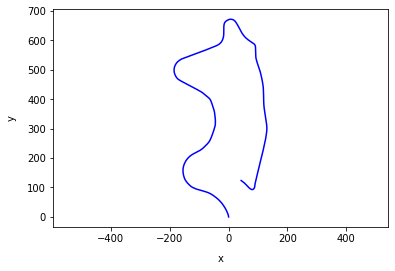

In [34]:
ResultSaver.vizCurrentTrajectory(fig_idx=1)

# 결과 분석 <a class="anchor" id="결과-분석"></a>

In [43]:
pose_list = ResultSaver.pose_list
_col, _row = pose_list.shape

Initial Point <= GPS zero 좌표
heading gps x,y, tan으로 제작

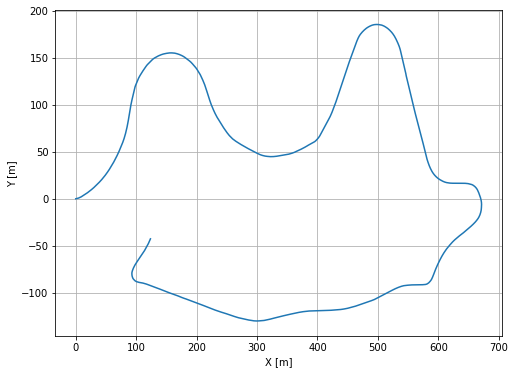

In [44]:
x_pos = pose_list[:,3]
y_pos = pose_list[:,7]

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(pose_list[:,3], pose_list[:,7])
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.grid();

plt.show()

In [37]:
gt_trajectory_lla = []  # [longitude(deg), latitude(deg), altitude(meter)] x N
gt_yaws = []  # [yaw_angle(rad),] x N
gt_yaw_rates= []  # [vehicle_yaw_rate(rad/s),] x N
gt_forward_velocities = []  # [vehicle_forward_velocity(m/s),] x N

for oxts_data in dataset.oxts:
    packet = oxts_data.packet
    gt_trajectory_lla.append([
        packet.lon,
        packet.lat,
        packet.alt
    ])
    gt_yaws.append(packet.yaw)
    gt_yaw_rates.append(packet.wz)
    gt_forward_velocities.append(packet.vf)

gt_trajectory_lla = np.array(gt_trajectory_lla).T
gt_yaws = np.array(gt_yaws)
gt_yaw_rates = np.array(gt_yaw_rates)
gt_forward_velocities = np.array(gt_forward_velocities)

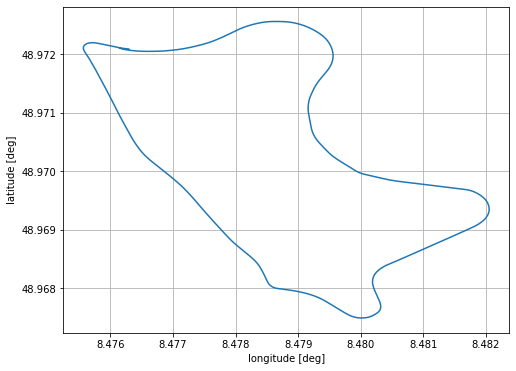

In [38]:
lons, lats, _ = gt_trajectory_lla

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(lons, lats)
ax.set_xlabel('longitude [deg]')
ax.set_ylabel('latitude [deg]')
ax.grid();

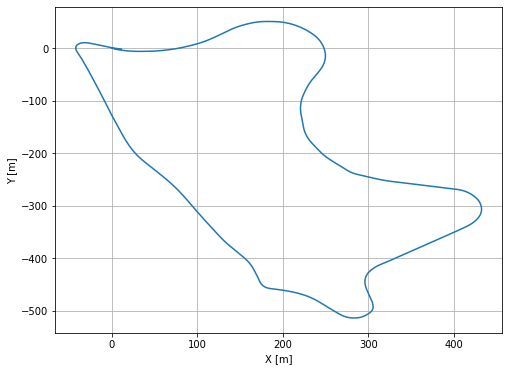

In [42]:
from utils.geo_transforms import lla_to_enu

origin = gt_trajectory_lla[:, 0]  # set the initial position to the origin
gt_trajectory_xyz = lla_to_enu(gt_trajectory_lla, origin)

xs, ys, _ = gt_trajectory_xyz
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(xs, ys)
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.grid();

# TODO 

* ground truth와 시점 일치 - help!!
* 매개변수 개선을 통해 Loop 완성시키기
* 프로파일링 - 뭐가 가장 오래 걸리나??
* 구글 드라이브 연동 - 데이터 로드도 느리고, 빌드도 상당히 걸립니다 ㅠㅠ 제일 나중에 작업!!

> # 다시 화이팅!!!!